In [1]:
import os
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


2025-05-02 21:41:56.206827: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
csv_path = "/Users/kashmithnisakya/Developer/Data_Science/Energy-Prediction-System/ml/data/processed/45_blending_machine_data_2025_03_04_09_32_15.csv"
model_name = "45_blending_machine"
features = ["energy"]
input_window = 3360
output_window = 3360
batch_size = 32
epochs = 50
hidden_size = 64
learning_rate = 0.001

In [3]:
def preprocess(csv_path, features, input_window, output_window):
    df = pd.read_csv(csv_path, parse_dates=["time"])
    df = df.sort_values("time").set_index("time")[features]

    # Store original energy for comparison
    original_energy = df["energy"].copy()

    # Handle zero values
    energy = df["energy"].copy()
    mask = energy == 0
    first_nonzero_idx = energy.ne(0).idxmax()
    mask.loc[:first_nonzero_idx] = False
    energy.loc[mask] = np.nan
    energy = energy.ffill()
    df["energy"] = energy
    df = df.ffill()

    # Plotting the original and filtered energy values
    plt.figure(figsize=(12, 6))
    plt.plot(
        df.index, original_energy, label="Original Energy", alpha=0.5, linestyle="--"
    )
    plt.plot(df.index, df["energy"], label="Filtered Energy", alpha=0.5)
    plt.title("Original vs Filtered Energy Values")
    plt.xlabel("Time")
    plt.ylabel("Energy Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)

    X, y = [], []
    for i in range(len(scaled) - input_window - output_window):
        X.append(scaled[i : i + input_window])
        y.append(scaled[i + input_window : i + input_window + output_window])

    X = np.array(X)
    y = np.array(y)
    print(f"✅ X shape: {X.shape}, y shape: {y.shape}")
    return X, y, scaler, df

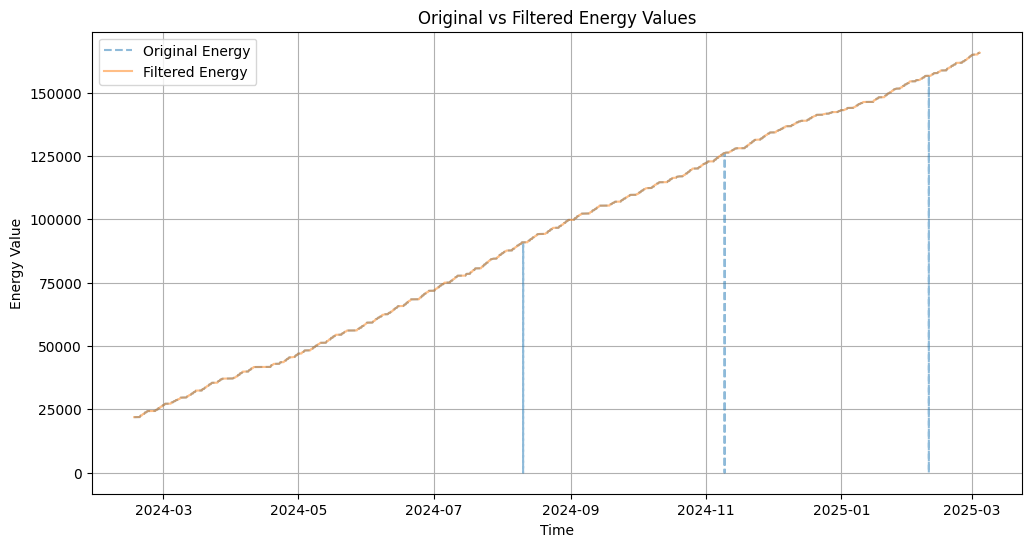

✅ X shape: (123280, 3360, 1), y shape: (123280, 3360, 1)


In [4]:
X, y, scaler, df_full = preprocess(csv_path, features, input_window, output_window)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [5]:
def build_model(input_shape, hidden_size, learning_rate):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(hidden_size, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(TimeDistributed(Dense(1, activation="relu")))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=["mae", "mse"],
    )
    return model


In [6]:
model = build_model(
    input_shape=(input_window, 1), hidden_size=hidden_size, learning_rate=learning_rate
)

2025-05-02 21:42:00.701661: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-02 21:42:00.702392: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-05-02 21:42:01.144924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-02 21:42:01.146825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] 

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3360, 64)          16896     
                                                                 
 dropout (Dropout)           (None, 3360, 64)          0         
                                                                 
 time_distributed (TimeDistr  (None, 3360, 1)          65        
 ibuted)                                                         
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [8]:
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [9]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)

In [10]:
ckpt = ModelCheckpoint(f"{model_name}.h5", monitor="val_loss", save_best_only=True)

In [11]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, reduce_lr, ckpt],
    verbose=1,
)

Epoch 1/50


2025-05-02 21:42:06.078388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-02 21:42:06.079777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-02 21:42:06.080395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3082/3082 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0166 - mse: 0.0011

2025-05-02 21:50:35.649975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-02 21:50:35.650830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-02 21:50:35.651301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3082/3082 [==============================] - 554s 179ms/step - loss: 0.0011 - mae: 0.0166 - mse: 0.0011 - val_loss: 2.2338e-04 - val_mae: 0.0065 - val_mse: 2.2338e-04 - lr: 0.0010
Epoch 2/50
3082/3082 [==============================] - 622s 202ms/step - loss: 2.0925e-04 - mae: 0.0101 - mse: 2.0925e-04 - val_loss: 1.5686e-04 - val_mae: 0.0086 - val_mse: 1.5686e-04 - lr: 0.0010
Epoch 3/50
3082/3082 [==============================] - 626s 203ms/step - loss: 1.4271e-04 - mae: 0.0088 - mse: 1.4271e-04 - val_loss: 6.4813e-05 - val_mae: 0.0061 - val_mse: 6.4813e-05 - lr: 0.0010
Epoch 4/50
3082/3082 [==============================] - 628s 204ms/step - loss: 1.3117e-04 - mae: 0.0086 - mse: 1.3117e-04 - val_loss: 4.5820e-05 - val_mae: 0.0057 - val_mse: 4.5820e-05 - lr: 0.0010
Epoch 5/50
3082/3082 [==============================] - 626s 203ms/step - loss: 1.2860e-04 - mae: 0.0086 - mse: 1.2860e-04 - val_loss: 4.6925e-05 - val_mae: 0.0058 - val_mse: 4.6925e-05 - lr: 0.0010
Epoch 6/50
3082/3082 [==

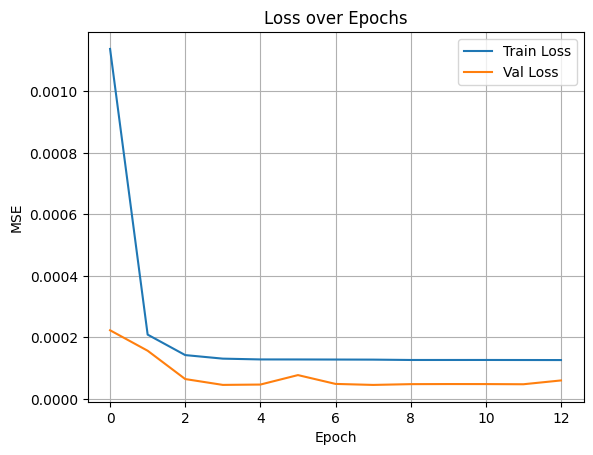

In [12]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.show()

In [13]:
sample_input = X_test[0:1]  # Shape (1, 3360, 1)
prediction = model.predict(sample_input)  # Shape (1, 3360, 1)

2025-05-02 23:56:33.582453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-02 23:56:33.583118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-02 23:56:33.583901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 466ms/step


In [14]:
# Inverse transform both y_test and prediction
true_future = scaler.inverse_transform(y_test[0])
predicted_future = scaler.inverse_transform(prediction[0])

In [15]:
# Get timestamps for plotting
start_time = df_full.index[-(output_window + 1)]
time_index = pd.date_range(
    start=start_time + pd.Timedelta(minutes=4), periods=output_window, freq="5min"
)

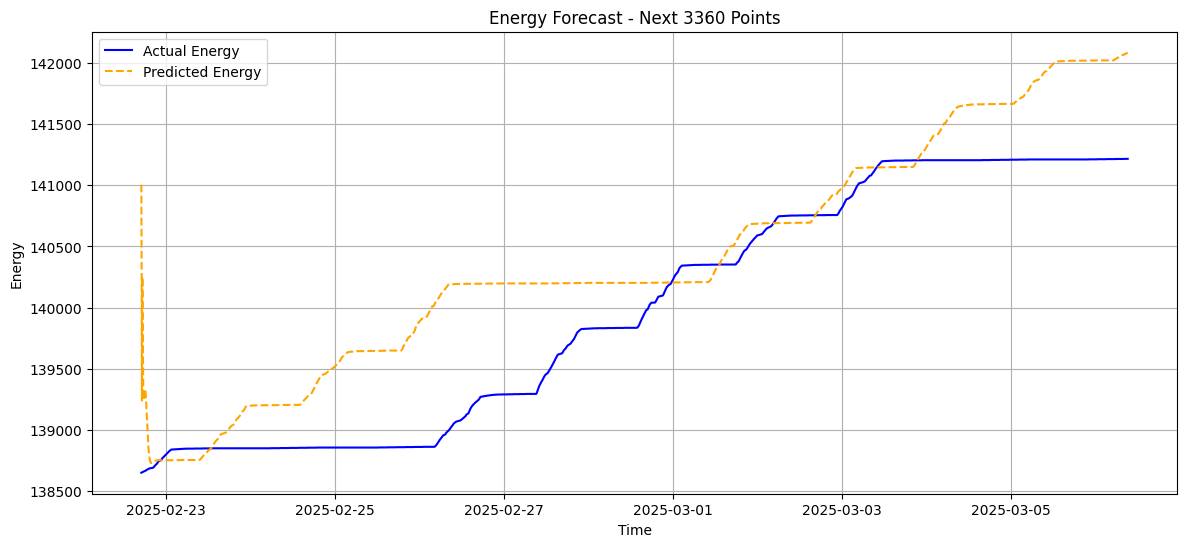

In [16]:
# Plot
plt.figure(figsize=(14, 6))
plt.plot(time_index, true_future, label="Actual Energy", color="blue")
plt.plot(
    time_index,
    predicted_future,
    label="Predicted Energy",
    linestyle="--",
    color="orange",
)
plt.title("Energy Forecast - Next 3360 Points")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.grid(True)
plt.legend()
plt.show()